In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastcluster
import statsmodels.stats.multitest as smm
import matplotlib
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.colors as colors
from matplotlib.colorbar import ColorbarBase
import math

print(np.__version__)

1.25.2


In [3]:
data = pd.read_csv('<Path to the file containting all brain HPA genesets>', sep='\t')
data.reset_index(inplace=True)
data.drop(columns={'index'}, inplace=True)
print(data.head())

                  0                                                  1
0    Adipose Tissue  ENSG00000175899;ENSG00000128274;ENSG0000015812...
1     Adrenal Gland  ENSG00000094914;ENSG00000114771;ENSG0000008788...
2             Blood  ENSG00000064687;ENSG00000140526;ENSG0000001119...
3      Blood Vessel  ENSG00000175899;ENSG00000128274;ENSG0000015812...
4  Brain - Amygdala  ENSG00000109576;ENSG00000149313;ENSG0000018304...


In [4]:
matrix = np.zeros((data.shape[0], data.shape[0]))
for i, row in data.iterrows():
    genes_ref = row[1].split(';')
    for j, col in data.iterrows():
        genes_col = col[1].split(';')
        matrix[i,j]  =  len(list(set(genes_ref) & set(genes_col)))/len(list(set(genes_ref).union(genes_col)))

/tmp/ipykernel_2894323/2948036870.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes_ref = row[1].split(';')
/tmp/ipykernel_2894323/2948036870.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  genes_col = col[1].split(';')


In [5]:
df_mat_u = pd.DataFrame(matrix)
df_mat_u.columns = data['0'].tolist()
df_mat_u.index = data['0'].tolist()

In [6]:
effects = pd.read_csv('<Path the file with the effect sizes on cognition for the genesets loaded before>', sep = '\t')
print(effects.head())

                    variable  Estimate        SE    tvalues         pvalue  \
0                  Intercept -0.266992  0.008402 -31.777150  3.902465e-221   
1  DEL_LOEUF_cat_1_gene_list -0.003108  0.080970  -0.038389   9.693775e-01   
2  DEL_LOEUF_cat_2_gene_list -0.078580  0.037412  -2.100411   3.569377e-02   
3  DEL_LOEUF_cat_3_gene_list  0.009034  0.018595   0.485809   6.271033e-01   
4    DEL_LOEUF_cat_1_outside -0.047259  0.004904  -9.636775   5.643651e-22   

   cat  win            aic            bic model_type  ... N_total_genes  \
0  NaN    0  663425.336401  663601.809409        3_3  ...           0.0   
1    g    1  663425.336401  663601.809409        3_3  ...         139.0   
2    g    2  663425.336401  663601.809409        3_3  ...         642.0   
3    g    3  663425.336401  663601.809409        3_3  ...        2256.0   
4    o    1  663425.336401  663601.809409        3_3  ...       13334.0   

   total_carriers                                       unique_genes  \
0       

In [7]:
effects = effects[(effects.cat == 'g') &
                (effects.ancestry == 'All') &
                (effects.diagnosis == 'wo_ASD') & 
                (effects.model_type == '1_3')]

new_data = pd.DataFrame()
for cnv_type in effects.TYPE.unique():
    for combo in set(zip(effects['model_type'], effects['win'],  effects['diagnosis'])):
        print(combo)
        tmp = effects[(effects.TYPE==cnv_type) & (effects.model_type==combo[0]) & (effects.win==combo[1]) & (effects.diagnosis==combo[2])].copy()
        tmp['pvalue_adj'] = smm.fdrcorrection(tmp['pvalue'])[1]
        new_data = pd.concat([new_data, tmp])
# new_data = new_data[new_data.pvalue_adj <= 0.05]

es_data = new_data.pivot(columns='TYPE', values='Estimate', index='gene_list_name')
pvalue_data = new_data.pivot(columns='TYPE', values='pvalue_adj', index='gene_list_name')
both = pd.merge(es_data, pvalue_data, on='gene_list_name')
es_data['one_sig'] = np.where((both.DEL_y < 0.05) | (both.DUP_y < 0.05), True, False)
both.reset_index(inplace=True)
es_data.reset_index(inplace=True)
print(new_data.head())



('1_3', 1, 'wo_ASD')
('1_3', 1, 'wo_ASD')
                variable  Estimate        SE   tvalues    pvalue cat  win  \
8    DEL_LOEUF_gene_list -0.009473  0.015765 -0.600902  0.547906   g    1   
38   DEL_LOEUF_gene_list -0.008060  0.016188 -0.497907  0.618550   g    1   
68   DEL_LOEUF_gene_list  0.032611  0.016011  2.036775  0.041674   g    1   
98   DEL_LOEUF_gene_list -0.036853  0.016969 -2.171745  0.029876   g    1   
128  DEL_LOEUF_gene_list -0.030387  0.016779 -1.811026  0.070138   g    1   

               aic            bic model_type  ... total_carriers  \
8    663425.544946  663581.256424        1_3  ...           2599   
38   663426.609759  663582.321237        1_3  ...           2760   
68   663408.030444  663563.741921        1_3  ...           1413   
98   663422.738519  663578.449996        1_3  ...           1777   
128  663411.488971  663567.200448        1_3  ...           2314   

                                          unique_genes  n_unique_genes  \
8    ENSG000

In [8]:
def compute_tagDS(es_data, data_CNV, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row.DEL + b*row.DUP + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row.DEL - row.DUP
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    es_data['tagDS'] = tagDS_vals 
    random_distri_tagDS = pd.read_csv('<Path to list of normalized tagDS for each geneset sizes>', sep='\t')
    tmp_data = pd.merge(es_data, data_CNV[data_CNV.TYPE=='DEL'].loc[:,['gene_list_name', 'gene_list_n']], on='gene_list_name', how='inner')
    print(tmp_data.gene_list_n.describe())
    tmp = pd.merge(tmp_data, random_distri_tagDS[['size', 'mu_s', 'sd_s']], left_on='gene_list_n', right_on='size', how='left')
    print(tmp.shape)
    tmp['zTagDS'] = (tmp['tagDS'] - tmp['mu_s'])/tmp['sd_s']
    return tmp

In [9]:
matrix_e = np.zeros((es_data.shape[0], es_data.shape[0]))
matrix_e[:] = np.nan


ratio =  0.426609501927956
print(ratio)

a = ratio
b = -1
c = 0

print(es_data)
es_data = compute_tagDS(es_data, new_data, ratio, b, c)
es_data['clean_tagDS'] = np.where(es_data.one_sig, es_data.zTagDS, 0)
print(es_data.shape)
        
for i, row in es_data.iterrows():
    for j, col in es_data.iterrows():
        if row.one_sig and col.one_sig:
            matrix_e[i,j]  =  (row.clean_tagDS + col.clean_tagDS) / 2


0.426609501927956
TYPE                             gene_list_name       DEL       DUP  one_sig
0                                Adipose Tissue -0.009473 -0.001166    False
1                                 Adrenal Gland -0.008060 -0.012074    False
2                                         Blood  0.032611  0.008457    False
3                                  Blood Vessel -0.036853 -0.009476    False
4                              Brain - Amygdala -0.030387 -0.008805    False
5      Brain - Anterior cingulate cortex (BA24)  0.015318 -0.045686     True
6               Brain - Caudate (basal ganglia) -0.045462  0.002456    False
7                 Brain - Cerebellar Hemisphere  0.033049 -0.008736    False
8                            Brain - Cerebellum  0.037395 -0.011170    False
9                                Brain - Cortex  0.005907 -0.032279     True
10                 Brain - Frontal Cortex (BA9)  0.012320 -0.055696     True
11                          Brain - Hippocampus -0.030367 

In [10]:
list_gtex = ['retina', 
             'esophagus', 
             'salivary gland', 
             'thyroid gland', 
             'lung', 
             'breast',
             'adrenal gland', 
             'adipose tissue', 
             'skin', 
             'heart muscle', 
             'liver', 
             'colon', 
             'kidney', 
             'stomach', 
             'small intestine', 
             'skeletal muscle', 
             'prostate', 
             'endometrium', 
             'ovary', 
             'vagina', 
             'spleen', 
             'testis', 
             'fallopian tube', 
             'pancreas', 
             'urinary bladder', 
             'cervix', ]

                                            0
0                              Adipose Tissue
1                               Adrenal Gland
2                                       Blood
3                                Blood Vessel
4                            Brain - Amygdala
5    Brain - Anterior cingulate cortex (BA24)
6             Brain - Caudate (basal ganglia)
7               Brain - Cerebellar Hemisphere
8                          Brain - Cerebellum
9                              Brain - Cortex
10               Brain - Frontal Cortex (BA9)
11                        Brain - Hippocampus
12                       Brain - Hypothalamus
13  Brain - Nucleus accumbens (basal ganglia)
14            Brain - Putamen (basal ganglia)
15         Brain - Spinal cord (cervical c-1)
16                   Brain - Substantia nigra
17                                     Breast
18                                      Colon
19                                  Esophagus
20                                

/tmp/ipykernel_2894323/2859512132.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  loeuf_cmap = matplotlib.cm.get_cmap('RdYlGn')


[30, 36, 18, 19, 0, 17, 25, 24, 3, 35, 31, 22, 2, 32, 20, 23, 26, 33, 34, 28, 29, 27, 1, 21, 7, 8, 15, 16, 5, 9, 10, 13, 6, 14, 12, 4, 11]



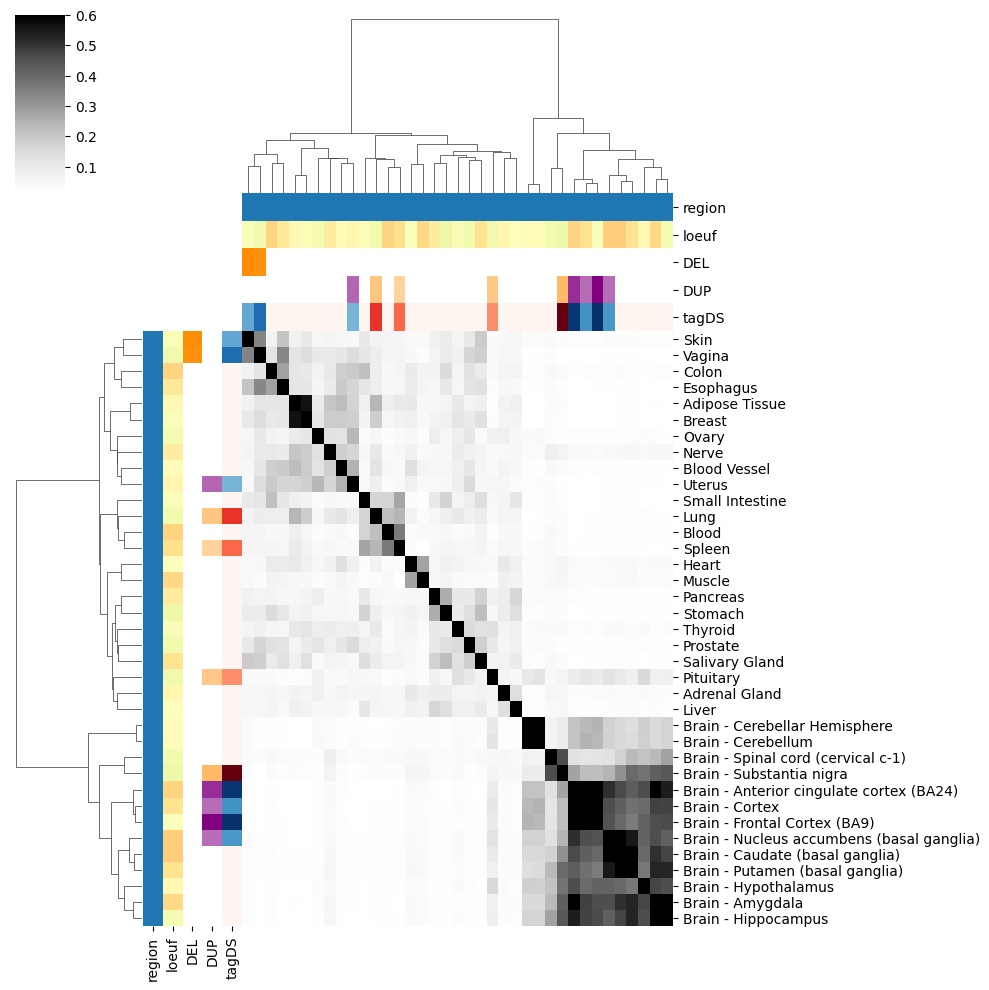

In [11]:
plt.rcParams['svg.fonttype'] = 'none'


df_mat = pd.DataFrame(matrix_e)
df_mat.columns = es_data['gene_list_name'].tolist()
df_mat.index = es_data['gene_list_name'].tolist()


test = [x for x in df_mat_u.columns]
tmp = pd.DataFrame(test)
print(tmp)
tmp[1] = np.where(tmp[0].isin(list_gtex), 'body', 'brain')
es_data['group'] = np.where(es_data['gene_list_name'].isin(list_gtex), 'body', 'brain')
lut = dict(zip(list(dict.fromkeys(tmp[1])), sns.color_palette("tab10", len(set(tmp[1]))).as_hex()))
print(lut)

loeuf_cmap = matplotlib.cm.get_cmap('RdYlGn')
loeufs = pd.read_csv('<Path to the computed average LOEUF value of every geneset>', sep='\t')
norm = plt.Normalize(0,2)

row_colors1 = loeuf_cmap(norm(loeufs.loeuf))
tmp_loeufs = [0.771, 0.913, 0.142, 0.906, 0.527, 1.169, 0.772]
row_colors1 = [matplotlib.colors.to_hex(c) for c in row_colors1]


bottom = LinearSegmentedColormap.from_list("mycmap", ['purple', "white"])
top = LinearSegmentedColormap.from_list("mycmap", [ "white", "darkorange"])

norm_top = plt.Normalize(0, new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max())
norm_bottom = plt.Normalize(-new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max(), 0)

both['b_del'] = [matplotlib.colors.to_hex(c) for c in bottom(norm_bottom(es_data.DEL))]
both['t_del'] = [matplotlib.colors.to_hex(c) for c in top(norm_top(es_data.DEL))]

print(es_data.head())
both['val_del'] = np.where(both['DEL_y'] > 0.05, 'white', np.where(both['DEL_x']>=0, both['t_del'], both['b_del']))

both['b_dup'] = [matplotlib.colors.to_hex(c) for c in bottom(norm_bottom(es_data.DUP))]
both['t_dup'] = [matplotlib.colors.to_hex(c) for c in top(norm_top(es_data.DUP))]

both['val_dup'] = np.where(both['DUP_y'] > 0.05, 'white', np.where(both['DUP_x']>=0, both['t_dup'], both['b_dup']))

colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
all_colors = np.vstack((colors_dup, colors_del))
del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)
divnorm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
tagDS_col = [matplotlib.colors.to_hex(c) for c in del_dup_spe(divnorm(es_data.clean_tagDS))]

row_colors = pd.DataFrame({'region': pd.Series(es_data['group']).map(lut),  'loeuf': row_colors1, 'DEL':both['val_del'], 'DUP':both['val_dup'], 'tagDS':tagDS_col})
row_colors.index = df_mat.index


print('N Del sig = {}'.format(both[both['DEL_y'] <= 0.05].shape[0]))
print('N Dup sig = {}'.format(both[both['DUP_y'] <= 0.05].shape[0]))

clstred = fastcluster.ward(df_mat_u)

cluster_union = sns.clustermap(df_mat_u, col_colors=row_colors, row_colors=row_colors, cmap='Greys', yticklabels=True,xticklabels=False, row_linkage = clstred, col_linkage = clstred, vmax=0.6)
print(cluster_union.dendrogram_row.reordered_ind)
print()

plt.show()

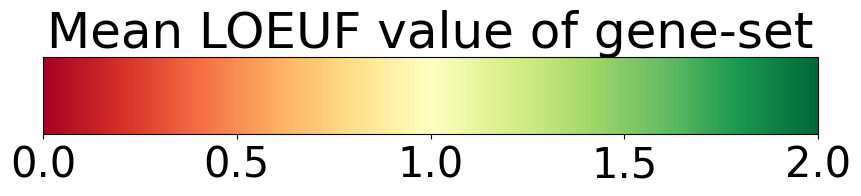

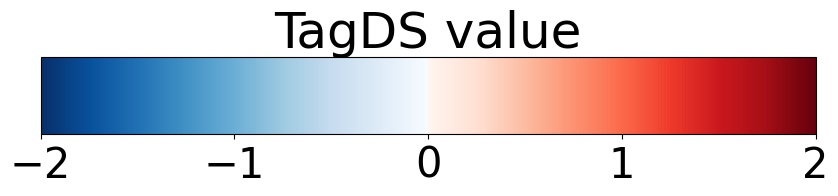

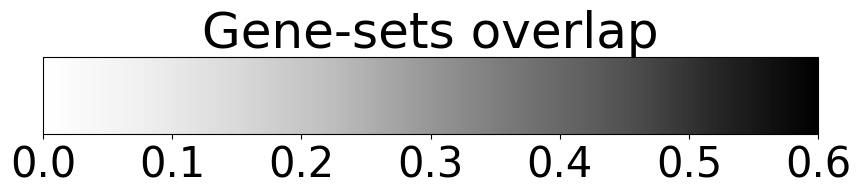

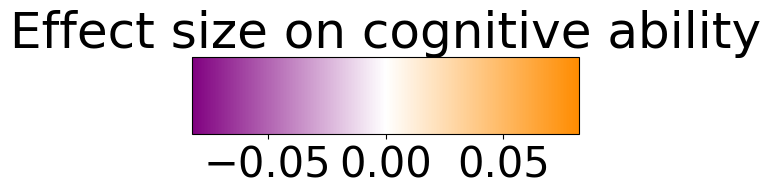

In [14]:
plt.rc('font', size=30)

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(10,1))
cbar = ColorbarBase(ax, cmap=loeuf_cmap, norm=plt.Normalize(vmin=0, vmax=2), orientation='horizontal')


# Show the plot
plt.title('Mean LOEUF value of gene-set')
plt.savefig('loeuf_cbar.svg', bbox_inches='tight')
plt.show()

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(10,1))
cbar = ColorbarBase(ax, cmap=del_dup_spe, norm=divnorm, orientation='horizontal')


# Show the plot
plt.title('TagDS value')
plt.savefig('effect_size_diff_cbar.svg', bbox_inches='tight')
plt.show()

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(10,1))
cbar = ColorbarBase(ax, cmap='Greys', norm=plt.Normalize(vmin=0, vmax=0.6), orientation='horizontal')


# Show the plot
plt.title('Gene-sets overlap')
plt.savefig('overlap_cbar.svg', bbox_inches='tight')
plt.show()


all_colors = np.vstack((bottom(np.linspace(0, 1, 256)),  top(np.linspace(0, 1, 256))))
del_dup_spe = LinearSegmentedColormap.from_list('del_dup_spe', all_colors)

# Create a colorbar
fig, ax = plt.subplots(1,figsize=(5,1))
cbar = ColorbarBase(ax, cmap=del_dup_spe, norm=TwoSlopeNorm(vmin=-new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max(), vcenter=0, vmax=new_data[new_data.pvalue_adj<=0.05].Estimate.abs().max()), orientation='horizontal')


# Show the plot
plt.title('Effect size on cognitive ability')
plt.savefig('effect_size.svg', bbox_inches='tight')

plt.show()